<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%ED%95%98%EC%88%9C%ED%9A%8C/Lab2_Pruning%EC%8B%A4%EC%8A%B5_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pruning model for MNIST dataset
find the differences between Unstructured Pruning and Structured Pruning
observe the structure of weights after the two pruning methods

In [ ]:
# # https://github.com/googlecolab/colabtools/issues/2600
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
!pip install numpy
!pip install tensorflow-model-optimization
!pip install matplotlib

In [ ]:
import shutil
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, datasets, utils, callbacks, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import tempfile
import os
%load_ext tensorboard



## Train a model for MNIST without pruning

To perform pruning on the ResNet-20 model, we will first try pruning a simpler custom model that classifies the MNIST dataset.

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.Conv2D(32, 5, padding='same', activation='relu', input_shape=(28,28,1)),
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
  keras.layers.Conv2D(64, 5, padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.ReLU(),
  keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
  keras.layers.Flatten(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)
# Print model summary
model.summary()

Epoch 1/4
1688/1688 [==============================] - 30s 6ms/step - loss: 0.1683 - accuracy: 0.9546 - val_loss: 0.0559 - val_accuracy: 0.9838
Epoch 2/4
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0654 - accuracy: 0.9808 - val_loss: 0.0506 - val_accuracy: 0.9882
Epoch 3/4
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0450 - accuracy: 0.9869 - val_loss: 0.0309 - val_accuracy: 0.9917
Epoch 4/4
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0342 - accuracy: 0.9894 - val_loss: 0.0284 - val_accuracy: 0.9937
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
           

In [ ]:
# Model accuracy before pruning
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9916999936103821
Saved baseline model to: /tmp/tmpvsncxy5l.h5


<ipython-input-5-fe27daf98d1b>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, keras_file, include_optimizer=False)


## Prune whole model

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params_sparsity_0_5 = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                              begin_step=0,
                                                              frequency=100)
}
model_whole_prune = keras.Sequential([
    keras.layers.Conv2D(
            32, 5, padding='same', activation='relu',
            input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Conv2D(
            64, 5, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(
            1024, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10)
])

model_whole_prune = prune_low_magnitude(model_whole_prune, **pruning_params_sparsity_0_5)

model_whole_prune.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_whole_prune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 28, 28, 32)        1634      
 _2 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_max_po  (None, 14, 14, 32)        1         
 oling2d_2 (PruneLowMagnitu                                      
 de)                                                             
                                                                 
 prune_low_magnitude_conv2d  (None, 14, 14, 64)        102466    
 _3 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_batch_  (None, 14, 14, 64)        257       
 normalization_1 (PruneLowM                                      
 agnitude)                                            

In [ ]:
# Model accuracy after pruning
batch_size = 128
epochs = 4

model_whole_prune.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=tfmot.sparsity.keras.UpdatePruningStep(),
    validation_split=0.1)

_, pruned_whole_model_accuracy = model_whole_prune.evaluate(test_images, test_labels, verbose=0)
print('Pruned whole model test accuracy:', pruned_whole_model_accuracy)

Epoch 1/4
422/422 [==============================] - 11s 12ms/step - loss: 0.2346 - accuracy: 0.9405 - val_loss: 0.1569 - val_accuracy: 0.9863
Epoch 2/4
422/422 [==============================] - 4s 8ms/step - loss: 0.0566 - accuracy: 0.9821 - val_loss: 0.0455 - val_accuracy: 0.9872
Epoch 3/4
422/422 [==============================] - 4s 8ms/step - loss: 0.0436 - accuracy: 0.9866 - val_loss: 0.0370 - val_accuracy: 0.9888
Epoch 4/4
422/422 [==============================] - 4s 8ms/step - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.0324 - val_accuracy: 0.9905
Pruned whole model test accuracy: 0.9909999966621399


## Prune model layer by layer

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params_2_by_4 = {
    'sparsity_m_by_n': (2, 4),
}
pruning_params_sparsity_0_5 = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                              begin_step=0,
                                                              frequency=100)
}
model_layer_prune = keras.Sequential([
    prune_low_magnitude(
        keras.layers.Conv2D(
            32, 5, padding='same', activation='relu',
            input_shape=(28, 28, 1),
            name="pruning_sparsity_0_5"),
        **pruning_params_sparsity_0_5),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    prune_low_magnitude(
        keras.layers.Conv2D(
            64, 5, padding='same',
            name="structural_pruning"),
        **pruning_params_2_by_4),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    keras.layers.Flatten(),
    prune_low_magnitude(
        keras.layers.Dense(
            1024, activation='relu',
            name="structural_pruning_dense"),
        **pruning_params_2_by_4),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(10)
])

model_layer_prune.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_layer_prune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_prunin  (None, 28, 28, 32)        1634      
 g_sparsity_0_5 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 prune_low_magnitude_struct  (None, 14, 14, 64)        102466    
 ural_pruning (PruneLowMagn                                      
 itude)                                                          
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                     

In [ ]:
# Model accuracy after pruning
batch_size = 128
epochs = 4

model_layer_prune.fit(
    train_images,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=tfmot.sparsity.keras.UpdatePruningStep(),
    validation_split=0.1)

_, pruned_layer_model_accuracy = model_layer_prune.evaluate(test_images, test_labels, verbose=0)
print('Pruned layer model test accuracy:', pruned_layer_model_accuracy)

Epoch 1/4
422/422 [==============================] - 7s 8ms/step - loss: 0.1868 - accuracy: 0.9449 - val_loss: 0.1455 - val_accuracy: 0.9890
Epoch 2/4
422/422 [==============================] - 3s 7ms/step - loss: 0.0577 - accuracy: 0.9818 - val_loss: 0.0409 - val_accuracy: 0.9877
Epoch 3/4
422/422 [==============================] - 3s 7ms/step - loss: 0.0412 - accuracy: 0.9866 - val_loss: 0.0395 - val_accuracy: 0.9873
Epoch 4/4
422/422 [==============================] - 3s 7ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0368 - val_accuracy: 0.9907
Pruned layer model test accuracy: 0.9908999800682068


In [ ]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned whole model test accuracy:', pruned_whole_model_accuracy)
print('Pruned layer model test accuracy:', pruned_layer_model_accuracy)

Baseline test accuracy: 0.9916999936103821
Pruned whole model test accuracy: 0.9909999966621399
Pruned layer model test accuracy: 0.9908999800682068


# Visualize

In [ ]:
# Once a model has been pruned to required sparsity, this method can be used to restore the original model with the sparse weights
model = model_layer_prune
model = tfmot.sparsity.keras.strip_pruning(model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_file = 'pruned_model_mnist.tflite'
print('Saved converted pruned model to:', tflite_file)
tf.io.write_file(tflite_file, tflite_model)

Saved converted pruned model to: pruned_model_mnist.tflite


In [ ]:
# Model Sparsity after pruning
from __future__ import print_function
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_utils


# Dont check layer if its name has one of word from this list.
IGNORE_LIST = [
    "relu", "pooling", "reshape", "identity", "input", "add", "flatten"
]

def ignore_tensor(details, ignore_list):
  """Returns boolean that indicates whether to ignore the tensor."""
  name = details["name"].casefold()
  if not name:
    return True
  for to_ignore in ignore_list:
    if to_ignore in name:
      return True
  return False

def calculate_sparsity(weights):
  number_of_weights = np.size(weights)
  number_of_non_zero_weights = np.count_nonzero(weights)
  sparsity = 1.0 - float(
      number_of_non_zero_weights
  ) / number_of_weights if number_of_non_zero_weights != 0 else 1.0
  return sparsity

def run(input_tflite_path, m_by_n):
  """Checks type of sparsity for each layer of the model."""

  interpreter = tf.lite.Interpreter(model_path=input_tflite_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()
  # Don't consider layers that can't be pruned.
  details = [x for x in details if not ignore_tensor(x, IGNORE_LIST)]

  for detail in details:
    name = detail["name"]
    shape = detail["shape"]
    weights = interpreter.tensor(detail["index"])()

    weights_ts = tf.constant(weights)
    pruned_m_by_n = pruning_utils.is_pruned_m_by_n(weights_ts, m_by_n, "C_IN")
    sparsity = calculate_sparsity(weights_ts)

    print(f"{name}: shape: {shape}, sparsity: {sparsity}, "
          f"{m_by_n[0]}_by_{m_by_n[1]} sparsity: {pruned_m_by_n}.")

if __name__ == "__main__":
  run(tflite_file, (2,4))


sequential_2/pruning_sparsity_0_5/Conv2D: shape: [32  5  5  1], sparsity: 0.5, 2_by_4 sparsity: True.
sequential_2/structural_pruning/Conv2D: shape: [64  5  5 32], sparsity: 0.5, 2_by_4 sparsity: True.
sequential_2/structural_pruning_dense/MatMul: shape: [1024 3136], sparsity: 0.5, 2_by_4 sparsity: True.
sequential_2/dense_4/MatMul: shape: [  10 1024], sparsity: 0.0, 2_by_4 sparsity: False.
StatefulPartitionedCall:0: shape: [ 1 10], sparsity: 0.30000000000000004, 2_by_4 sparsity: False.
Conv_hwcn_weights: shape: [25 32], sparsity: 0.49, 2_by_4 sparsity: False.
Conv_hwcn_weights: shape: [800  64], sparsity: 0.20017578125000002, 2_by_4 sparsity: False.


In [ ]:
# Load tflite file with the created pruned model
interpreter = tf.lite.Interpreter(model_path=tflite_file)
interpreter.allocate_tensors()

details = interpreter.get_tensor_details()

# Weights of the dense layer that has been pruned.
tensor_name = 'structural_pruning_dense/MatMul'
detail = [x for x in details if tensor_name in x["name"]]

# We need the first layer.
tensor_data = interpreter.tensor(detail[0]["index"])()

In [ ]:
print(f"Shape of Dense layer is {tensor_data.shape}")

Shape of Dense layer is (1024, 3136)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# The value 24 is chosen for convenience.
width = height = 24

subset_values_to_display = tensor_data[0:height, 0:width]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(subset_values_to_display) > 0, val_ones, val_zeros)

In [ ]:
def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

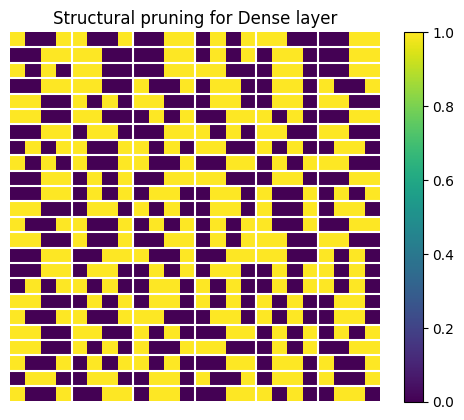

In [ ]:
plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structural pruning for Dense layer")
plt.show()

In [ ]:
# Get weights of the convolutional layer that has been pruned with 2 by 4 sparsity.
tensor_name = 'structural_pruning/Conv2D'
detail = [x for x in details if tensor_name in x["name"]]
tensor_data = interpreter.tensor(detail[1]["index"])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (64, 5, 5, 32)


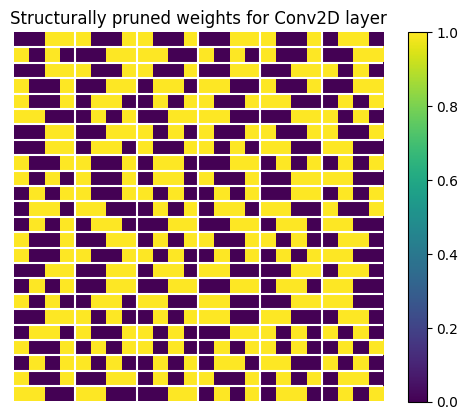

In [ ]:
weights_to_display = tf.reshape(tensor_data, [tf.reduce_prod(tensor_data.shape[:-1]), -1])
weights_to_display = weights_to_display[0:width, 0:height]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 1e-9, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Structurally pruned weights for Conv2D layer")
plt.show()

In [ ]:
# Get weights of the convolutional layer that has been pruned with random pruning.
tensor_name = 'pruning_sparsity_0_5/Conv2D'
detail = [x for x in details if tensor_name in x["name"]]
tensor_data = interpreter.tensor(detail[0]["index"])()
print(f"Shape of the weight tensor is {tensor_data.shape}")

Shape of the weight tensor is (32, 5, 5, 1)


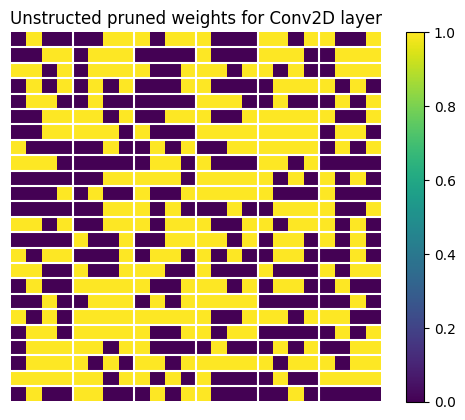

In [ ]:
weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
weights_to_display = weights_to_display[0:width, 0:height]

val_ones = np.ones([height, width])
val_zeros = np.zeros([height, width])
subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

plot_separation_lines(height, width)

plt.axis('off')
plt.imshow(subset_values_to_display)
plt.colorbar()
plt.title("Unstructed pruned weights for Conv2D layer")
plt.show()